## Data Customer Classification.

### Limpieza y transformacion de datos

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('data_customer_classification.csv')
data

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78
...,...,...,...
124995,CS8433,26-Jun-11,64
124996,CS7232,19-Aug-14,38
124997,CS8731,28-Nov-14,42
124998,CS8133,14-Dec-13,13


Se realiza la limpieza de datos
* customer_id -> str
* trans_date -> datetime DD-MM-YYYY
* tran_amount -> float

In [3]:
data['customer_id'] = data['customer_id'].astype('str')
data['trans_date'] = pd.to_datetime(data['trans_date'], format='%d-%b-%y').dt.strftime('%d-%m-%Y')
data['tran_amount'] = pd.to_numeric(data['tran_amount'], errors='coerce')
data['tran_amount'] = data['tran_amount'].round(2)
data

,customer_id,trans_date,tran_amount
0,CS5295,11-02-2013,35
1,CS4768,15-03-2015,39
2,CS2122,26-02-2013,52
3,CS1217,16-11-2011,99
4,CS1850,20-11-2013,78
...,...,...,...
124995,CS8433,26-06-2011,64
124996,CS7232,19-08-2014,38
124997,CS8731,28-11-2014,42
124998,CS8133,14-12-2013,13


Como tal no poseemos una clasificacion para poder categorizar a nuestros clientes. Por lo que primero con los datos que poseemos obtendremos la frecuencia con la que el cliente realiza compras en nuestra tienda. Esto lo realizaremos de la siguiente manera:

In [4]:
frequency_client_purchase = data.groupby('customer_id')['trans_date'].count().reset_index()
frequency_client_purchase = frequency_client_purchase.rename(columns={'trans_date': 'frequency_purchase'})

frequency_client_purchase

,customer_id,frequency_purchase
0,CS1112,15
1,CS1113,20
2,CS1114,19
3,CS1115,22
4,CS1116,13
...,...,...
6884,CS8996,13
6885,CS8997,14
6886,CS8998,13
6887,CS8999,12


Ahora obtendremos las siguientes medidas de dispersion, como la media, el minimo, y el maximo. Pero principalmente utilizaremos el percentil 25%, 50%, 75%. Eso para poder clasificar con que frecuencia compran nuestros clientes que poseemos por ahora. Se hara de la siguiente manera:
* Abajo del percentil 25% se tomaran como clientes bajos
* Arriba del percentil 75% se tomaran como clientes altos
* Los demas seran clientes medios

In [5]:
summary_of_frecuency_client_purchase = frequency_client_purchase['frequency_purchase'].describe()
summary_of_frecuency_client_purchase

count    6889.000000
mean       18.144869
std         5.193014
min         4.000000
25%        14.000000
50%        18.000000
75%        22.000000
max        39.000000
Name: frequency_purchase, dtype: float64

Ahora obtendremos el total de compras que realizan los clientes.

In [6]:
total_purchases_per_customer = data.groupby('customer_id')['tran_amount'].sum().reset_index()
total_purchases_per_customer = total_purchases_per_customer.rename(columns={'tran_amount': 'total_purchase'})

total_purchases_per_customer

,customer_id,total_purchase
0,CS1112,1012
1,CS1113,1490
2,CS1114,1432
3,CS1115,1659
4,CS1116,857
...,...,...
6884,CS8996,582
6885,CS8997,543
6886,CS8998,624
6887,CS8999,383


Y como en el caso de la frecuencia de compra, seguiremos la misma logica:
* Abajo del percentil 25% se tomaran como clientes bajos
* Arriba del percentil 75% se tomaran como clientes altos
* Los demas seran clientes medios

In [7]:
summary_of_total_purchases_per_customer = total_purchases_per_customer['total_purchase'].describe()
summary_of_total_purchases_per_customer

count    6889.000000
mean     1179.269705
std       465.832609
min       149.000000
25%       781.000000
50%      1227.000000
75%      1520.000000
max      2933.000000
Name: total_purchase, dtype: float64

In [8]:
def define_category_of_client(row):
    if row['total_purchase'] <= 781 and row['frequency_purchase'] <= 14:
        return 1
    elif row['total_purchase'] >= 1520 and row['frequency_purchase'] >= 22:
        return 3
    else:
        return 2


Al final obtendremos un solo dataframe que contenga la frecuencia de compra, el total de compra y que tipo de categorizacion sera:
* 1 seran clientes bajos
* 2 seran clientes medios
* 3 seran clientes altos

In [58]:
df_combined = pd.merge(total_purchases_per_customer, frequency_client_purchase, on='customer_id')
df_combined['client_category'] = df_combined.apply(define_category_of_client, axis=1)
df_combined.to_csv('df_combined.csv', index=False)
df_combined

,customer_id,total_purchase,frequency_purchase,client_category
0,CS1112,1012,15,2
1,CS1113,1490,20,2
2,CS1114,1432,19,2
3,CS1115,1659,22,3
4,CS1116,857,13,2
...,...,...,...,...
6884,CS8996,582,13,1
6885,CS8997,543,14,1
6886,CS8998,624,13,1
6887,CS8999,383,12,1


Por ultimo, realizaremos un grafico de dispersion para poder ver como es que estan clasificados nuestros clientes y corroborrar que se realizo de la manera correcta.

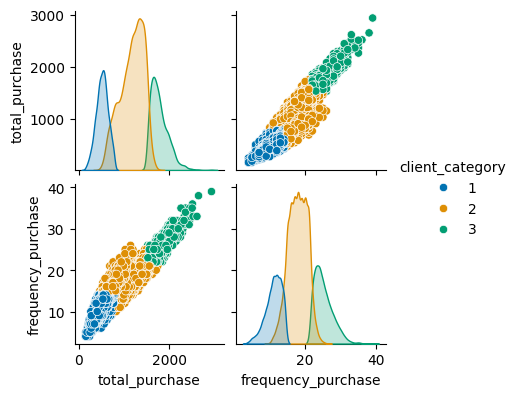

In [10]:
sns.pairplot(df_combined, hue='client_category', height=2, palette='colorblind')
plt.show()

### Construccion modelo 

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Divideremos los datos en características (X) y etiquetas (y), donde x seran los valores para poder predecir y y sera el valor resultante predicto. 

In [21]:
X = df_combined[['total_purchase', 'frequency_purchase']].values
y = df_combined['client_category'].values

Escalaremos los datos x para tenerlos normalizados, es decir, tener valores entre 0-1

In [22]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Repartiremos el 100% de los datos en 80% para entrenar el modelo y el resto para poder realizar test.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train - 1, num_classes=3)  # Resta 1 para que las categorías sean 0, 1 y 2

Crearemos el modelo secuencial donde todas las capas estan conectadas entre si. 
* La primer capa utilizara 64 neuoras e input 2 ya que son las dos caracteristicas que se utilizaran. 
* La segunda capa tendra la mitad y con una funcion de activacion relu
* La tercera capa tendra 3 ya que son los 3 tipos de clasificacion que hay para este problema, ademas que para problemas de clasificacion en la ultima capa es recomendable utilizar la funcion de activacion de softmax, basicamente brinda probabilidades para cada clase

In [24]:
model = Sequential()
model.add(Dense(64, input_dim=2, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

Compilar el modelo, utilizando loss como parametro para la funcion perdida que para problemas de clasificacion se utiliza 'categorical_crossentropy', optimizer para ajustar los pesos de la red neuronal.

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Entrenamos el modelo, con 50 epocas ya que no es un problema tan exigente. Donde en cada entrenamiento se dividaran en espacios de 32.

In [26]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
173/173 [==============================] - 1s 2ms/step - loss: 0.5004 - accuracy: 0.8694
Epoch 2/50
173/173 [==============================] - 0s 3ms/step - loss: 0.1132 - accuracy: 0.9750
Epoch 3/50
173/173 [==============================] - 0s 2ms/step - loss: 0.0766 - accuracy: 0.9786
Epoch 4/50
173/173 [==============================] - 0s 2ms/step - loss: 0.0629 - accuracy: 0.9831
Epoch 5/50
173/173 [==============================] - 0s 2ms/step - loss: 0.0512 - accuracy: 0.9864
Epoch 6/50
173/173 [==============================] - 0s 2ms/step - loss: 0.0443 - accuracy: 0.9906
Epoch 7/50
173/173 [==============================] - 0s 2ms/step - loss: 0.0375 - accuracy: 0.9920
Epoch 8/50
173/173 [==============================] - 0s 2ms/step - loss: 0.0345 - accuracy: 0.9913
Epoch 9/50
173/173 [==============================] - 0s 2ms/step - loss: 0.0306 - accuracy: 0.9927
Epoch 10/50
173/173 [==============================] - 0s 2ms/step - loss: 0.0259 - accuracy: 0.9942

Ahora comprobaremos cuanto fue la perdida del modelo y la exactitud del modelo que para este caso es del 0.99, es decir del 99%

In [28]:
y_test_encoded = to_categorical(y_test - 1, num_classes=3)
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Loss: {loss}, Accuracy: {accuracy}')

44/44 [==============================] - 0s 2ms/step - loss: 0.0237 - accuracy: 0.9927
Loss: 0.023728491738438606, Accuracy: 0.9927431344985962


In [29]:
model.save('data_customer_classification.h5')

/home/yossu/anaconda3/envs/PruebaTecnicaGBM/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Pruebas unitarias. 

In [53]:
from keras.models import load_model

In [54]:
def prediction_model(value_purchase, value_frequency):
    model = load_model('data_customer_classification.h5')

    nuevos_datos = np.array([[value_purchase, value_frequency]])  

    nuevos_datos = scaler.transform(nuevos_datos)

    predicciones = model.predict(nuevos_datos)

    categorias_predichas = np.argmax(predicciones, axis=1) + 1  
    return categorias_predichas

In [56]:
print(prediction_model(1525, 25)) # 3 -> High client
print(prediction_model(779, 10)) # 1 -> low client
print(prediction_model(1250, 15)) # 2 -> medium client

1/1 [==============================] - 0s 52ms/step
[3]
1/1 [==============================] - 0s 76ms/step
[1]
1/1 [==============================] - 0s 51ms/step
[2]
